# Product Back Order classification Problem

## 1. Import Libraries

In [2]:
# For EDA and Preprocessing
import pandas as pd
from datetime import datetime
import numpy as np
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, OrdinalEncoder,RobustScaler

# For pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Prediction                   
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
 
warnings.filterwarnings('ignore')

## 2. Load Datasets

In [3]:
train = pd.read_csv('../Datasets/Kaggle_Training_Dataset_v2.csv',sep=',')
test = pd.read_csv('../Datasets/Kaggle_Test_Dataset_v2.csv',sep=',')

In [4]:
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [5]:
test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


In [6]:
# Combine two datasets
combined_dataset = pd.concat([train,test],ignore_index=True)
# Check the completeness 
assert (train.shape[0]+test.shape[0])==combined_dataset.shape[0]

## 3. Exporatory Data Analysis (EDA)

### 3.1 Data Consideration
This process will consider about the data cleaning to ensure the quality, integrity, and usefulness of data.

In [7]:
# Check combined dataset
combined_dataset.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [8]:
# Check dataset shape
combined_dataset.shape

(1929937, 23)

In [9]:
# Check dataset columns
combined_dataset.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [10]:
# Check dataset features type
combined_dataset.dtypes

sku                   object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue       object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [11]:
# Checking numerical and categorical features
numerical_cols = []
categorical_cols = []

for column in combined_dataset.columns:
    if pd.api.types.is_numeric_dtype(combined_dataset[column]):
        numerical_cols.append(column)
    else:
        categorical_cols.append(column)

print(f'Numerical Features: {len(numerical_cols)} ,{numerical_cols}')     
print(f'Categorical Features: {len(categorical_cols)} ,{categorical_cols}')     

Numerical Features: 15 ,['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
Categorical Features: 8 ,['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [12]:
# Redefined categorial features (we not used 'sku' which is product ID features)
categorical_cols.remove('sku') 

In [13]:
# Describe the combined dataset
combined_dataset.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.929935e+06,1.814318e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06
mean,4.965683e+02,7.878627e+00,4.306440e+01,1.785399e+02,3.454659e+02,5.066067e+02,5.536816e+01,1.746639e+02,3.415653e+02,5.235771e+02,5.277637e+01,2.016193e+00,-6.899870e+00,-6.462343e+00,6.537039e-01
std,2.957343e+04,7.054212e+00,1.295420e+03,5.108770e+03,9.831562e+03,1.434543e+04,1.884377e+03,5.188856e+03,9.585030e+03,1.473327e+04,1.257968e+03,2.296112e+02,2.659988e+01,2.588343e+01,3.543230e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.600000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.510592e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


Features 'perf_6_month_avg' and 'perf_12_month_avg' have the -99.0 which seem to be missing values and filled with -99.0

In [14]:
# Counts -99.0 in feature 'perf_6_month_avg'
combined_dataset['perf_6_month_avg'].value_counts()

 0.99     163323
 1.00     150339
-99.00    148579
 0.73     128818
 0.98      97390
           ...  
 0.20        921
 0.03        829
 0.04        724
 0.01        648
 0.29        572
Name: perf_6_month_avg, Length: 102, dtype: int64

In [15]:
# Counts -99.0 in feature 'perf_12_month_avg'
combined_dataset['perf_12_month_avg'].value_counts()

 0.99     152682
-99.00    140025
 0.78     131353
 0.98     106119
 0.97      74113
           ...  
 0.23        895
 0.06        873
 0.05        743
 0.03        639
 0.02        437
Name: perf_12_month_avg, Length: 102, dtype: int64

In [16]:
# Check Missing Values in combined_dataset
combined_dataset.isna().sum()

sku                       0
national_inv              2
lead_time            115619
in_transit_qty            2
forecast_3_month          2
forecast_6_month          2
forecast_9_month          2
sales_1_month             2
sales_3_month             2
sales_6_month             2
sales_9_month             2
min_bank                  2
potential_issue           2
pieces_past_due           2
perf_6_month_avg          2
perf_12_month_avg         2
local_bo_qty              2
deck_risk                 2
oe_constraint             2
ppap_risk                 2
stop_auto_buy             2
rev_stop                  2
went_on_backorder         2
dtype: int64

There might be 2 rows that contains all missing values. Let's check that..

In [17]:
# Check for all missing rows
combined_dataset[combined_dataset['went_on_backorder'].isna()]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929936,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Check that missing rows are contain all missing values
combined_dataset[combined_dataset['went_on_backorder'].isna()].all()

sku                  True
national_inv         True
lead_time            True
in_transit_qty       True
forecast_3_month     True
forecast_6_month     True
forecast_9_month     True
sales_1_month        True
sales_3_month        True
sales_6_month        True
sales_9_month        True
min_bank             True
potential_issue      True
pieces_past_due      True
perf_6_month_avg     True
perf_12_month_avg    True
local_bo_qty         True
deck_risk            True
oe_constraint        True
ppap_risk            True
stop_auto_buy        True
rev_stop             True
went_on_backorder    True
dtype: bool

In [19]:
# Drop 2 missing rows
combined_dataset.drop(combined_dataset[combined_dataset['sku'] == '(1687860 rows)'].index,inplace=True)
combined_dataset.drop(combined_dataset[combined_dataset['sku'] == '(242075 rows)'].index,inplace=True)

In [20]:
# Recheck missing rows again
combined_dataset.isna().sum()

sku                       0
national_inv              0
lead_time            115617
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [21]:
# LabelEncoder the target features
target_col = LabelEncoder().fit_transform(combined_dataset['went_on_backorder'])
combined_dataset['went_on_backorder']= target_col

### 3.2 Univariate Analysis

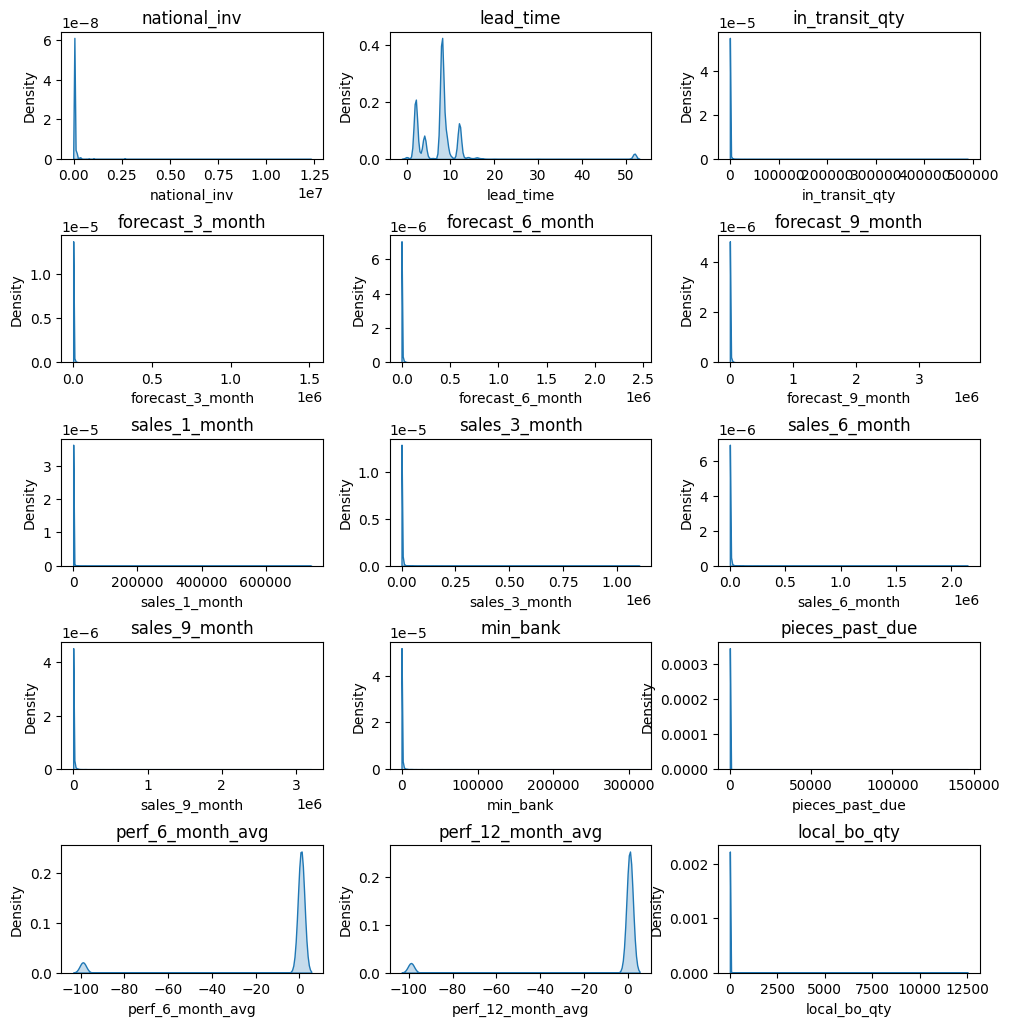

In [22]:
# Check the skrew of data
# Create subplots for kde plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
fig.tight_layout()

# Iterate through the list and create kde plots
for i, k in enumerate(numerical_cols):
    row, col = divmod(i, 3)
    sns.kdeplot(data = combined_dataset,x=k, fill=True, ax=axes[row, col])
    axes[row, col].set_title(k)
plt.subplots_adjust(hspace=0.6)
plt.show()

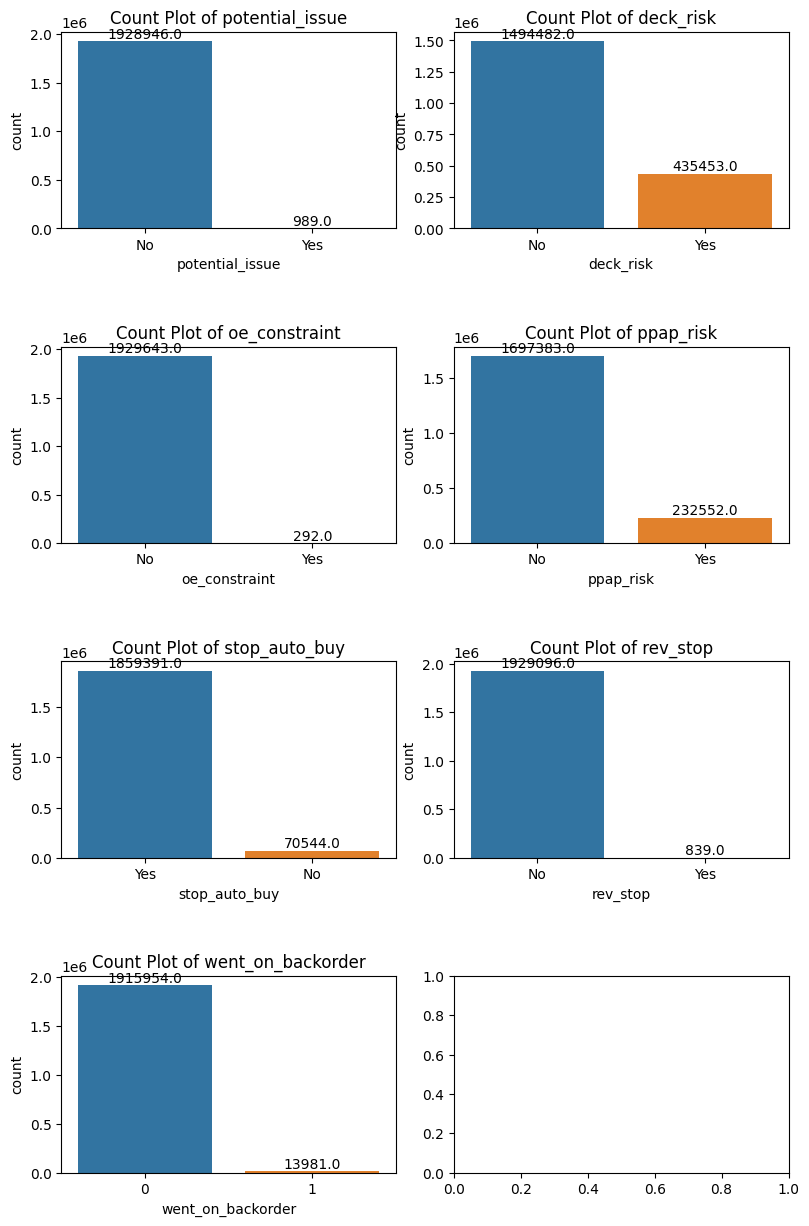

In [23]:
# Countplot for categorical features
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 12))
fig.tight_layout()

# Iterate through the list of categorical features and create count plots
for i, feature in enumerate(categorical_cols):
    row, col = divmod(i, 2)
    ax = sns.countplot(data=combined_dataset, x=feature, ax=axes[row, col])
     # Add count annotations above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
    axes[row, col].set_title(f'Count Plot of {feature}')
plt.subplots_adjust(hspace=0.6)
plt.show()

### 3.3 Multivariate Analysis

In [24]:
#Calculate the outliers 
def outlier_count(col, data):
    
    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculate your inter quatile
    iqr = q75 - q25
    
    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [25]:
#Loop the outliers function to find the percent of data that is outliers
for col in combined_dataset[numerical_cols]:
    outlier_count(col,combined_dataset)


---------------national_inv---------------

Number of outliers: 290377
Percent of data that is outlier: 15.05%

---------------in_transit_qty---------------

Number of outliers: 387993
Percent of data that is outlier: 20.1%

---------------forecast_3_month---------------

Number of outliers: 393975
Percent of data that is outlier: 20.41%

---------------forecast_6_month---------------

Number of outliers: 377668
Percent of data that is outlier: 19.57%

---------------forecast_9_month---------------

Number of outliers: 375040
Percent of data that is outlier: 19.43%

---------------sales_1_month---------------

Number of outliers: 340098
Percent of data that is outlier: 17.62%

---------------sales_3_month---------------

Number of outliers: 333283
Percent of data that is outlier: 17.27%

---------------sales_6_month---------------

Number of outliers: 333316
Percent of data that is outlier: 17.27%

---------------sales_9_month---------------

Number of outliers: 333927
Percent of data

<Axes: >

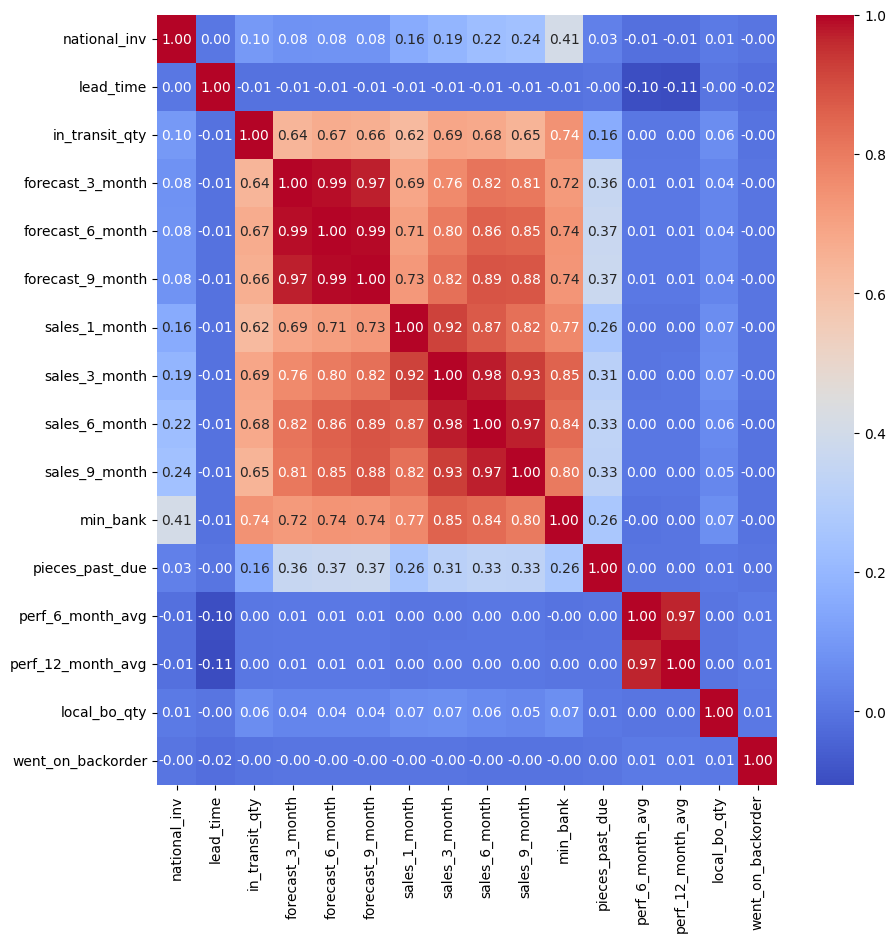

In [23]:
# Correlation Matrix 
plt.figure(figsize=(10,10))
sns.heatmap(combined_dataset.corr(), fmt=".2f", annot=True, cmap="coolwarm")

<Axes: xlabel='x', ylabel='y'>

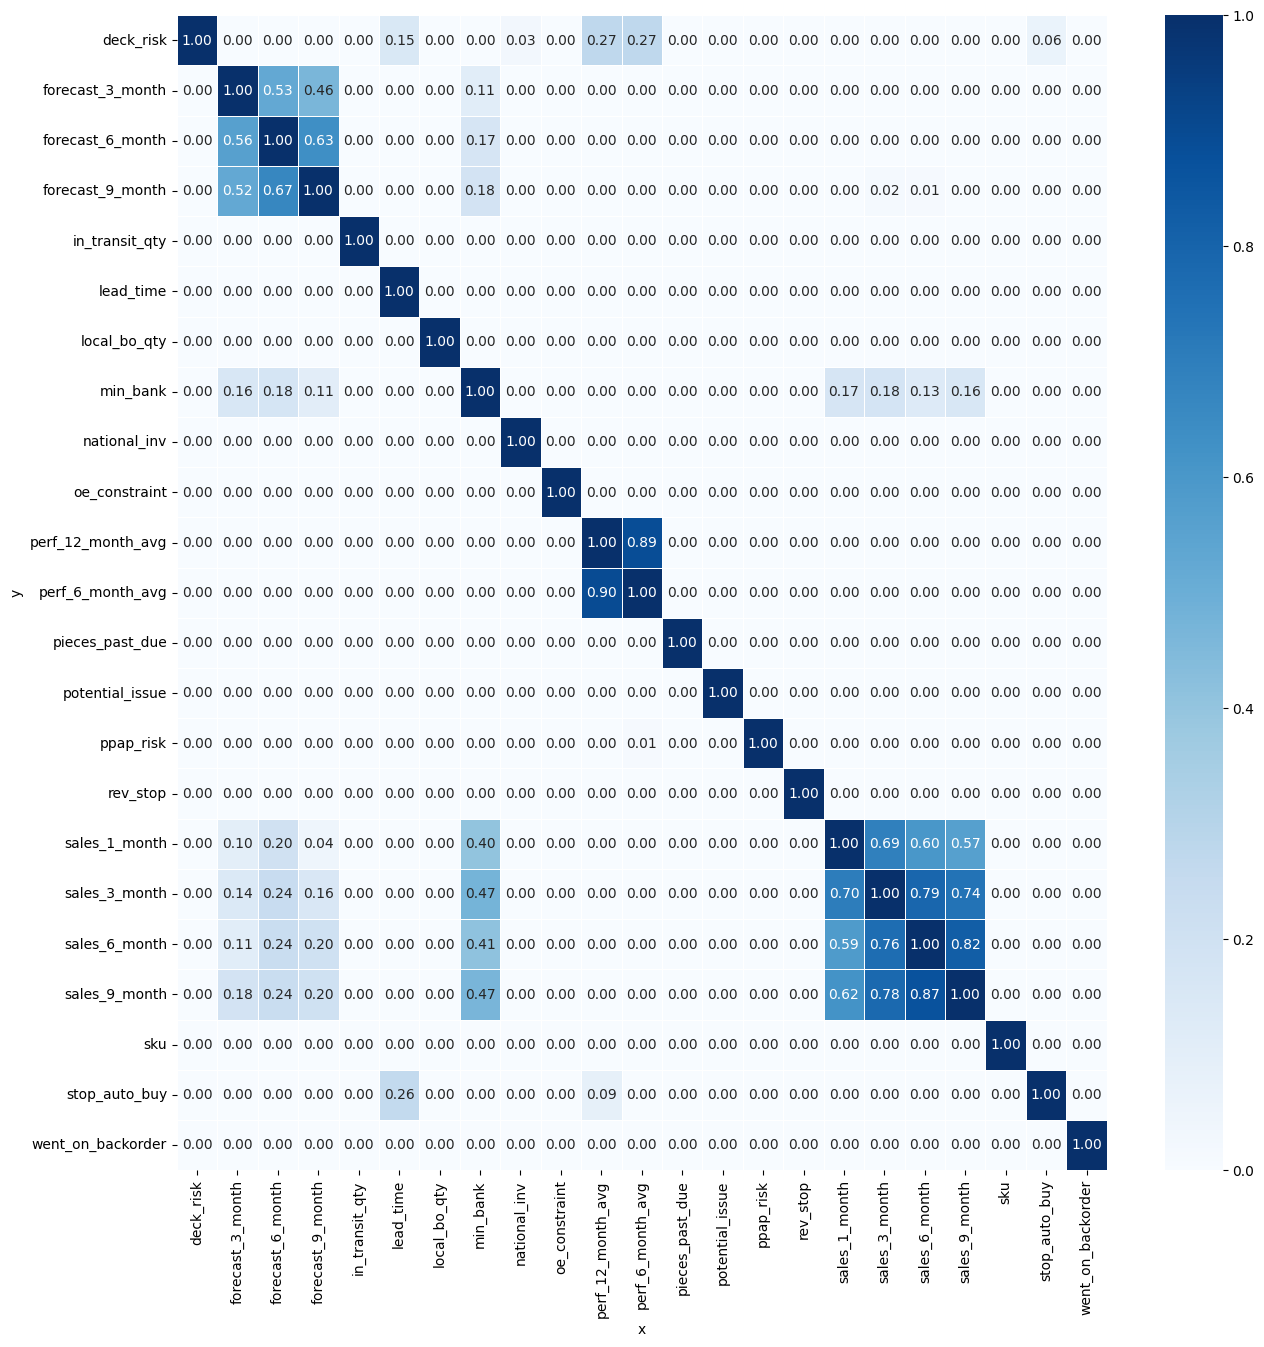

In [24]:
# Predictive Power Score
#Create another dataframe to used with pps (just in case that adjusting the features for this)
df_pps=combined_dataset.copy()
matrix_df_pps = pps.matrix(df_pps)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(15,15))
sns.heatmap(matrix_df_pps, vmin=0, vmax=1, fmt=".2f", cmap="Blues", linewidths=0.5, annot=True)

## 4. Preprocessing

### 4.1 Train and Test Split

In [26]:
# Assign the X,y
X = combined_dataset.drop(columns='went_on_backorder')
y= pd.DataFrame(combined_dataset['went_on_backorder'])

In [27]:
# Split train and test datasets in the ratio 70:30 (we got a lot of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7040)

In [28]:
# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1350954, 22)
X_test shape: (578981, 22)
y_train shape: (1350954, 1)
y_test shape: (578981, 1)


### 4.2 Imputation

In [29]:
# Check missing value in X_train
X_train.isna().sum()

sku                      0
national_inv             0
lead_time            81017
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
dtype: int64

In [29]:
# Check unique values of missing features
missing_features= ['lead_time','perf_6_month_avg','perf_12_month_avg']
for i in missing_features:
    print(i,X_train[i].unique(),'\n')

lead_time [14.  8. 12.  2.  4. 52.  3.  9. 16. 11. nan 15.  0. 10.  5. 17.  6. 13.
 24. 20.  7. 22. 21. 30. 18. 26. 40.  1. 35. 28. 19. 25. 23.] 

perf_6_month_avg [ 9.9e-01  8.0e-01  6.3e-01  4.3e-01  9.4e-01  1.0e+00  0.0e+00  9.8e-01
  9.5e-01 -9.9e+01  7.4e-01  9.6e-01  2.7e-01  8.5e-01  9.1e-01  7.8e-01
  6.6e-01  9.0e-01  5.0e-01  5.7e-01  8.6e-01  2.2e-01  9.7e-01  7.7e-01
  7.6e-01  6.9e-01  4.6e-01  9.3e-01  1.8e-01  3.1e-01  8.9e-01  8.8e-01
  8.3e-01  7.0e-01  7.9e-01  7.3e-01  4.8e-01  2.4e-01  8.2e-01  8.7e-01
  1.0e-01  8.4e-01  4.1e-01  6.8e-01  5.2e-01  3.7e-01  7.1e-01  9.2e-01
  5.1e-01  2.3e-01  6.5e-01  6.0e-01  5.6e-01  5.8e-01  5.4e-01  2.0e-02
  4.2e-01  4.4e-01  3.5e-01  2.1e-01  3.9e-01  4.0e-01  4.9e-01  6.1e-01
  6.2e-01  8.1e-01  2.8e-01  1.5e-01  3.6e-01  7.0e-02  7.5e-01  5.9e-01
  3.3e-01  6.4e-01  1.3e-01  9.0e-02  3.4e-01  6.7e-01  1.7e-01  3.8e-01
  2.6e-01  2.0e-01  4.0e-02  3.2e-01  5.3e-01  3.0e-02  5.5e-01  4.7e-01
  2.5e-01  8.0e-02  1.2e-01  1.4e

Imputation:<br>
'lead_time' = np.nan<br>
'perf_6_month_avg' = -99.0<br>
'perf_12_month_avg' = -99.0<br>

In [30]:
# There are any "-99.0" left in other features?
for feature in X_train.columns:
    unique_values = X_train[feature].unique()
    if -99.0 in unique_values:
        print(f"Feature {feature} contains -99.0 ")

Feature national_inv contains -99.0 
Feature perf_6_month_avg contains -99.0 
Feature perf_12_month_avg contains -99.0 


Imputation(updated):<br>
'lead_time' = np.nan<br>
'perf_6_month_avg' = -99.0<br>
'perf_12_month_avg' = -99.0<br>
'national_inv' = -99.0<br>

In [31]:
# updated missing features
missing_features.append('national_inv')
missing_features

['lead_time', 'perf_6_month_avg', 'perf_12_month_avg', 'national_inv']

In [32]:
# Create the imputers for nan and -99
imp_null = SimpleImputer(missing_values=np.nan, strategy= 'most_frequent')
imp_neg99 = SimpleImputer(missing_values= -99.0, strategy= 'most_frequent')

In [33]:
# fit_transform imputers for X_train and transform imputers for X_test
X_train['lead_time']= imp_null.fit_transform(X_train[['lead_time']])
X_test['lead_time']= imp_null.transform(X_test[['lead_time']])

X_train['national_inv'] = imp_neg99.fit_transform(X_train[['national_inv']])
X_test['national_inv']= imp_neg99.transform(X_test[['national_inv']])

X_train['perf_6_month_avg'] = imp_neg99.fit_transform(X_train[['perf_6_month_avg']])
X_test['perf_6_month_avg']= imp_neg99.transform(X_test[['perf_6_month_avg']])

X_train['perf_12_month_avg'] = imp_neg99.fit_transform(X_train[['perf_12_month_avg']])
X_test['perf_12_month_avg']= imp_neg99.transform(X_test[['perf_12_month_avg']])

In [34]:
# Check that imputer works
print(f"X_train lead_time: {X_train['lead_time'].isna().sum()}")
print(f"X_train national_inv: {len(X_train[X_train['national_inv'] == -99])}")
print(f"X_train perf_6_month_avg: {len(X_train[X_train['perf_6_month_avg'] == -99])}")
print(f"X_train perf_12_month_avg: {len(X_train[X_train['perf_12_month_avg'] == -99])}\n")

print(f"X_test lead_time: {X_train['lead_time'].isna().sum()}")
print(f"X_test national_inv: {len(X_train[X_train['national_inv'] == -99])}")
print(f"X_test perf_6_month_avg: {len(X_train[X_train['perf_6_month_avg'] == -99])}")
print(f"X_test perf_12_month_avg: {len(X_train[X_train['perf_12_month_avg'] == -99])}")

X_train lead_time: 0
X_train national_inv: 0
X_train perf_6_month_avg: 0
X_train perf_12_month_avg: 0

X_test lead_time: 0
X_test national_inv: 0
X_test perf_6_month_avg: 0
X_test perf_12_month_avg: 0


In [35]:
# Create Pipeline for imputation
impute = Pipeline(
    steps=[
        ('impute_null',imp_null),
        ('impute_(-99.0)',imp_neg99)
    ]
)

In [36]:
# Create ColumnTransformer for imputation
imputer = ColumnTransformer(    
    transformers=[
        ("impute", impute, missing_features)
    ], remainder='passthrough', verbose_feature_names_out=False
).set_output(transform='pandas')

### 4.3 Standardization and Scaling

In [37]:
# Shows the numerical features
numerical_cols

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']

In [38]:
# 'pieces_past_due','local_bo_qty' features will use Robuts Scaler due to their outliers.
# Others numerical features will use MinMax Scaling because they are highly skewed.
robust_features=['pieces_past_due','local_bo_qty']
minmax_features=[col for col in numerical_cols if col not in robust_features]

In [39]:
# Create MinMaxScaler,RobustScaler
minmaxscaler =MinMaxScaler()
robustscaler = RobustScaler()

In [40]:
# Fit and Transform MinMaxScaler into minmax_features
X_train[minmax_features] = minmaxscaler.fit_transform(X_train[minmax_features])
X_test[minmax_features] = minmaxscaler.transform(X_test[minmax_features])
# Fit and Transform RobustScaler into RobustScaler
X_train[robust_features] = robustscaler.fit_transform(X_train[robust_features])
X_test[robust_features] = robustscaler.transform(X_test[robust_features])

In [41]:
# Check the results from MinMaxScaler
X_train[minmax_features].head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,perf_6_month_avg,perf_12_month_avg
519658,0.002057,0.269231,0.00000,6.619921e-07,0.000001,0.000001,0.000001,0.000003,1.863390e-06,0.000002,0.000006,0.99,0.99
1184550,0.002056,0.153846,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.80,0.82
440461,0.002059,0.230769,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9.316951e-07,0.000002,0.000000,0.63,0.72
227290,0.002056,0.038462,0.00001,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.43,0.19
1190017,0.002059,0.153846,0.00000,0.000000e+00,0.000008,0.000011,0.000000,0.000006,1.118034e-05,0.000010,0.000003,0.94,0.97


In [42]:
# Check the results from RobustScaler
X_train[robust_features].head()

,pieces_past_due,local_bo_qty
519658,0.0,0.0
1184550,0.0,0.0
440461,0.0,0.0
227290,0.0,0.0
1190017,0.0,0.0


In [43]:
# Create ColumnTransformer for scaling
scaler = ColumnTransformer(
    transformers=[
        ('scaler_minmax',minmaxscaler,minmax_features),
        ('scaler_robust',robustscaler,robust_features)
    ]
    ,remainder='passthrough',verbose_feature_names_out=False
).set_output(transform='pandas')

### 4.4 Encoding

In [44]:
# Create the encode_cols for encoding
encode_cols = categorical_cols.copy()
encode_cols.remove('went_on_backorder')
print(encode_cols)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


In [45]:
# Create label encoder
labelencoder = LabelEncoder()

In [46]:
# Iterate through each categorical feature and encode it
for feature in encode_cols:
    X_train[feature] = labelencoder.fit_transform(X_train[feature])
    X_test[feature] = labelencoder.transform(X_test[feature])


In [47]:
# Check the label encoding result
X_train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
519658,1867616,0.002057,0.269231,0.00000,6.619921e-07,0.000001,0.000001,0.000001,0.000003,1.863390e-06,...,0,0.0,0.99,0.99,0.0,0,0,0,1,0
1184550,1553554,0.002056,0.153846,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0,0.0,0.80,0.82,0.0,0,0,0,1,0
440461,1788443,0.002059,0.230769,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9.316951e-07,...,0,0.0,0.63,0.72,0.0,0,0,0,1,0
227290,1338851,0.002056,0.038462,0.00001,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0,0.0,0.43,0.19,0.0,1,0,1,1,0
1190017,1559412,0.002059,0.153846,0.00000,0.000000e+00,0.000008,0.000011,0.000000,0.000006,1.118034e-05,...,0,0.0,0.94,0.97,0.0,0,0,0,1,0


In [48]:
# Create ColumnTransformer for encoding
# All category features are using LableEncoder
encoder = ColumnTransformer(
    transformers=  [
        ('encoder_label',OrdinalEncoder(),encode_cols)
    ]
    ,remainder='passthrough'
)

In [49]:
# Create a pipeline for preprocessing
Preprocessor = Pipeline([
    ('imputation',imputer),
    ('scaling',scaler),
    ('encoding',encoder),
])

In [51]:
# Create Pipeline for all steps 
pipeline = Pipeline([
    ('preprocessing',Preprocessor),
    # Try with RandomForest Classifier algorithm
    ('prediction',RandomForestClassifier())
])

### Prepocessing Result

In [52]:
X_train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
519658,1867616,0.002057,0.269231,0.00000,6.619921e-07,0.000001,0.000001,0.000001,0.000003,1.863390e-06,...,0,0.0,0.99,0.99,0.0,0,0,0,1,0
1184550,1553554,0.002056,0.153846,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0,0.0,0.80,0.82,0.0,0,0,0,1,0
440461,1788443,0.002059,0.230769,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9.316951e-07,...,0,0.0,0.63,0.72,0.0,0,0,0,1,0
227290,1338851,0.002056,0.038462,0.00001,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0,0.0,0.43,0.19,0.0,1,0,1,1,0
1190017,1559412,0.002059,0.153846,0.00000,0.000000e+00,0.000008,0.000011,0.000000,0.000006,1.118034e-05,...,0,0.0,0.94,0.97,0.0,0,0,0,1,0


In [53]:
X_test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
92912,1204412,0.002056,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0,0.0,1.00,0.82,0.0,0,0,0,1,0
1780727,3372695,0.002087,0.038462,0.000254,0.000430,0.000630,0.000638,0.000109,4.537300e-04,6.955104e-04,...,0,0.0,0.87,0.90,0.0,0,0,0,1,0
262829,1610813,0.002056,0.173077,0.000000,0.000003,0.000002,0.000001,0.000000,0.000000e+00,0.000000e+00,...,0,0.0,0.68,0.66,0.0,0,0,1,1,0
584898,1932864,0.002056,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,9.056486e-07,4.658476e-07,...,0,0.0,0.59,0.61,0.0,0,0,0,1,0
1672297,3271573,0.002056,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.658476e-07,...,0,0.0,0.79,0.79,0.0,0,0,0,1,0


### Prediction (Testing)

In [54]:
# Split another train and test datasets for testing the pipeline
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 7040)

In [55]:
# Train the model
pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('impute',
                                                                   Pipeline(steps=[('impute_null',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('impute_(-99.0)',
                                                                                    SimpleImputer(missing_values=-99.0,
                                                                                                  strategy='most_frequent'))]),
                                                                   ['lead_time',
                                                                    'perf_6_month_avg',
                                                                    'perf_12_month_avg',
                                                                    'national_inv']...
                                                                    'perf_12_month_avg']),
                                                                  ('scaler_robust',
                                                                   RobustScaler(),
                                                                   ['pieces_past_due',
                                                                    'local_bo_qty'])],
                                                    verbose_feature_names_out=False)),
                                 ('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encoder_label',
                                                                   OrdinalEncoder(),
                                                                   ['potential_issue',
                                                                    'deck_risk',
                                                                    'oe_constraint',
                                                                    'ppap_risk',
                                                                    'stop_auto_buy',
                                                                    'rev_stop'])]))])),
                ('prediction', RandomForestClassifier())])

In [56]:
# Accuracy score
pipeline.score(X_test1,np.ravel(y_test1))

0.9932709363519701

Overfitting!

In [57]:
# Perform the prediction
y_pred1=pipeline.predict(X_test1)

In [58]:
# Check the f1_core
from sklearn.metrics import f1_score
f1_score(np.ravel(y_test1),y_pred1)

0.1660958904109589

In [ ]:
y.value_counts()

went_on_backorder
0                    1915954
1                      13981
dtype: int64

The target feature is highly imbalance. So we need to handle the imbalance class.